## Get df for Installations historically

In [1]:
import pandas as pd

# Sample data (replace this with your data)
df = pd.read_csv("report1695648769200.csv", encoding='latin1', dtype={"Installation Address - ZIP Code": str})

# Convert "Installation End Date" to datetime format and extract the date part only
df.dropna(subset=['Installation End Date'], inplace=True)
df.dropna(subset=['Installation Address - ZIP Code'], inplace=True)
df['Installation End Date'] = pd.to_datetime(df['Installation End Date'], format="%d.%m.%Y, %H:%M")
df['zip_code_2_digits'] = df['Installation Address - ZIP Code'].astype(str).str[:2]

# Determine the earliest date in 'Installation End Date'
earliest_date = df['Installation End Date'].min()
print(f"Earliest Installation End Date: {earliest_date}")

# First, calculate the cumulative installations up to 01.01.2022
cumulative_df = df[df['Installation End Date'] < pd.to_datetime('01.01.2022')].groupby('zip_code_2_digits').size().reset_index(name='cumulative_installations')

# Filter out dates before 01.01.2022 for the weekly counts
df = df[df['Installation End Date'] >= pd.to_datetime('01.01.2022')]

# Set 'Installation End Date' as the index for groupby with pd.Grouper to work
df.set_index('Installation End Date', inplace=True)

# Group by week and zip-code
weekly_counts = df.groupby(['zip_code_2_digits', pd.Grouper(freq='W-MON')]).size().reset_index(name='weekly_installations')

# Shift the weekly counts to get counts for 2 and 4 weeks prior
weekly_counts['installations_1_weeks_ago'] = weekly_counts.groupby('zip_code_2_digits')['weekly_installations'].shift(1)
weekly_counts['installations_2_weeks_ago'] = weekly_counts.groupby('zip_code_2_digits')['weekly_installations'].shift(2)
weekly_counts['installations_4_weeks_ago'] = weekly_counts.groupby('zip_code_2_digits')['weekly_installations'].shift(4)

# Merge with cumulative counts
result = pd.merge(weekly_counts, cumulative_df, on='zip_code_2_digits', how='left')

# Update cumulative counts
result['cumulative_installations'] += result.groupby('zip_code_2_digits')['weekly_installations'].cumsum() - result['weekly_installations']

# Fill NaN values with 0
result.fillna(0, inplace=True)

FileNotFoundError: ignored

In [ ]:
result

,zip_code_2_digits,Installation End Date,weekly_installations,installations_1_weeks_ago,installations_2_weeks_ago,installations_4_weeks_ago,cumulative_installations
0,01,2022-01-10,1,0.0,0.0,0.0,216.0
1,01,2022-01-24,2,1.0,0.0,0.0,217.0
2,01,2022-01-31,4,2.0,1.0,0.0,219.0
3,01,2022-02-07,4,4.0,2.0,0.0,223.0
4,01,2022-02-14,3,4.0,4.0,1.0,227.0
...,...,...,...,...,...,...,...
7604,99,2023-08-28,11,4.0,7.0,5.0,651.0
7605,99,2023-09-04,8,11.0,4.0,5.0,662.0
7606,99,2023-09-11,10,8.0,11.0,7.0,670.0
7607,99,2023-09-18,4,10.0,8.0,4.0,680.0


In [ ]:
import pandas as pd

# Convert the 'dates' column to datetime format
result['Installation End Date'] = pd.to_datetime(result['Installation End Date'])

# Filter the DataFrame to only consider dates in the year 2023
result = result[result['Installation End Date'].dt.year == 2023]

# Calculate the calendar week and add it as a new column
result['calendar_week'] = result['Installation End Date'].dt.isocalendar().week

# Pivot the DataFrame
df_pivot = result.pivot(index='zip_code_2_digits', columns='calendar_week', values='weekly_installations')

df_pivot.to_csv("df_pivot.csv")

<ipython-input-3-d12ae27641c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['calendar_week'] = result['Installation End Date'].dt.isocalendar().week


Some check

In [ ]:
# Determine the earliest date in 'Installation End Date'
earliest_date = result['Installation End Date'].min()
print(f"Earliest Installation End Date: {earliest_date}")


Earliest Installation End Date: 2022-01-03 00:00:00


## Get df with Actuals (SE = QM Assessment minus two weeks)

In [ ]:
import pandas as pd

# Load the CSV into a DataFrame (replace 'your_file.csv' with your file name)
service_df = pd.read_csv("SE_Forecast_QM Cases_new.csv", encoding='latin1', dtype={"Billing Zip/Postal Code": str})

# Assuming the date column in this new CSV is also named "Installation End Date"
# Convert to datetime format
service_df.dropna(subset=['QM Assessement: Created Date'], inplace=True)
service_df.dropna(subset=['Billing Zip/Postal Code'], inplace=True)
service_df['zip_code_2_digits'] = service_df['Billing Zip/Postal Code'].astype(str).str[:2]
service_df['QM Assessement: Created Date'] = pd.to_datetime(service_df['QM Assessement: Created Date'], format='%d.%m.%Y')

# Filter rows from 01.01.2022 onwards
service_df = service_df[service_df['QM Assessement: Created Date'] >= '2022-01-01']

# Set 'Installation End Date' as index
service_df.set_index('QM Assessement: Created Date', inplace=True)

# Group by zip code and calendar week, then count the number of service cases
weekly_service_counts = service_df.groupby(['zip_code_2_digits', pd.Grouper(freq='W-MON')]).size().reset_index(name='weekly_service_cases')

# Rename the date column for consistency
weekly_service_counts.rename(columns={'QM Assessement: Created Date': 'Installation End Date'}, inplace=True)

# Calculate the rolling average of the last 4 weeks for service cases
weekly_service_counts['avg_last_4_weeks'] = weekly_service_counts.groupby('zip_code_2_digits')['weekly_service_cases'].rolling(window=4).mean().reset_index(level=0, drop=True)

# Shift the weekly service counts and average counts two weeks backward
weekly_service_counts['weekly_service_cases'] = weekly_service_counts.groupby('zip_code_2_digits')['weekly_service_cases'].shift(-2)
weekly_service_counts['avg_last_4_weeks'] = weekly_service_counts.groupby('zip_code_2_digits')['avg_last_4_weeks'].shift(-2)

# Drop rows which now have NaN values due to the shift (the last two weeks of data for each zip code)
weekly_service_counts.dropna(subset=['weekly_service_cases', 'avg_last_4_weeks'], inplace=True)

# Now, filter out rows before 01.01.2022 to only show data from 01.01.2022 onward
weekly_service_counts = weekly_service_counts[weekly_service_counts['Installation End Date'] >= '2022-01-01']

# Fill NaN values with 0 (as the rolling average of the first 3 weeks will be NaN)
weekly_service_counts['avg_last_4_weeks'].fillna(0, inplace=True)


In [ ]:
import pandas as pd

# Load the CSV into a DataFrame (replace 'your_file.csv' with your file name)
service_df = pd.read_csv("report1695651446178.csv", encoding='latin1', dtype={"Billing Zip/Postal Code": str})

# Assuming the date column in this new CSV is also named "Installation End Date"
# Convert to datetime format
service_df.dropna(subset=['QM Assessement: Created Date'], inplace=True)
service_df.dropna(subset=['Billing Zip/Postal Code'], inplace=True)
service_df['zip_code_2_digits'] = service_df['Billing Zip/Postal Code'].astype(str).str[:2]
service_df['QM Assessement: Created Date'] = pd.to_datetime(service_df['QM Assessement: Created Date'], format='%d.%m.%Y')

# Filter rows from 01.01.2022 onwards
service_df = service_df[service_df['QM Assessement: Created Date'] >= '2023-01-01']

service_df['calendar_week'] = service_df['QM Assessement: Created Date'].dt.isocalendar().week

weekly_service_counts = service_df.groupby(['zip_code_2_digits', 'calendar_week']).size().reset_index(name='weekly_service_cases')

# Pivot the DataFrame
df_pivot_QM = weekly_service_counts.pivot(index='zip_code_2_digits', columns='calendar_week', values='weekly_service_cases')

df_pivot_QM.to_csv("df_pivot_QM.csv")

In [ ]:
df_pivot_QM

calendar_week,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
zip_code_2_digits,,,,,,,,,,,,,,,,,,,,,
01,NaN,3.0,3.0,2.0,NaN,2.0,4.0,2.0,2.0,1.0,...,NaN,2.0,2.0,3.0,NaN,NaN,1.0,2.0,2.0,NaN
02,2.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
03,4.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,2.0,1.0,...,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,NaN,1.0
04,NaN,2.0,4.0,2.0,1.0,2.0,1.0,2.0,NaN,2.0,...,NaN,2.0,5.0,5.0,1.0,2.0,3.0,2.0,4.0,NaN
06,NaN,5.0,4.0,9.0,1.0,2.0,NaN,4.0,2.0,5.0,...,NaN,7.0,4.0,10.0,NaN,4.0,10.0,4.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,2.0,NaN,1.0,1.0,3.0,2.0,NaN,2.0,...,1.0,1.0,NaN,1.0,NaN,1.0,NaN,5.0,2.0,NaN
96,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,1.0,4.0,2.0,NaN,NaN,1.0,3.0,2.0,1.0,2.0
97,1.0,2.0,1.0,1.0,1.0,NaN,4.0,2.0,NaN,1.0,...,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,1.0,1.0


In [ ]:
weekly_service_counts

,zip_code_2_digits,calendar_week,weekly_service_cases,avg_last_4_weeks
3,01,5,3,2.75
4,01,6,2,2.50
5,01,7,4,2.75
6,01,8,2,2.75
7,01,9,4,3.00
...,...,...,...,...
2851,99,36,1,3.25
2852,99,37,2,2.75
2853,99,45,1,2.00
2854,99,51,10,3.50


## Merge both dfs


In [ ]:
# Generate all possible combinations of zip codes and weeks
all_zip_codes = pd.concat([result['zip_code_2_digits'], weekly_service_counts['zip_code_2_digits']]).unique()
all_dates = pd.date_range(start='2022-01-01', end=max(result['Installation End Date'].max(), weekly_service_counts['Installation End Date'].max()), freq='W-MON')

combinations = pd.DataFrame({
    'zip_code_2_digits': [zip_code for zip_code in all_zip_codes for date in all_dates],
    'Installation End Date': list(all_dates) * len(all_zip_codes)
})

# Left merge combinations with weekly_service_counts
merged_service_df = pd.merge(combinations, weekly_service_counts, on=['zip_code_2_digits', 'Installation End Date'], how='left')

# Left merge combinations with result
merged_result_df = pd.merge(combinations, result, on=['zip_code_2_digits', 'Installation End Date'], how='left')

# Merge the two DataFrames together
final_df = pd.merge(merged_result_df, merged_service_df, on=['zip_code_2_digits', 'Installation End Date'], how='outer')

# Fill NaN values with suitable defaults
final_df.fillna({
    'weekly_installations': 0,
    'two_weeks_ago_installations': 0,
    'four_weeks_ago_installations': 0,
    'cumulative_installations': 0,
    'weekly_service_cases': 0,
    'avg_last_4_weeks': 0
}, inplace=True)


In [ ]:
# Sorting by date first and then by zip code
final_df = final_df.sort_values(by=['Installation End Date', 'zip_code_2_digits'])

In [ ]:
final_df

,zip_code_2_digits,Installation End Date,weekly_installations,installations_1_weeks_ago,installations_2_weeks_ago,installations_4_weeks_ago,cumulative_installations,weekly_service_cases,avg_last_4_weeks
0,01,2022-01-03,0.0,NaN,NaN,NaN,0.0,0.0,0.0
89,02,2022-01-03,1.0,0.0,0.0,0.0,94.0,0.0,0.0
178,03,2022-01-03,0.0,NaN,NaN,NaN,0.0,0.0,0.0
267,04,2022-01-03,1.0,0.0,0.0,0.0,236.0,0.0,0.0
356,06,2022-01-03,1.0,0.0,0.0,0.0,385.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8098,95,2023-09-11,2.0,2.0,6.0,9.0,316.0,0.0,0.0
8187,96,2023-09-11,2.0,5.0,7.0,4.0,443.0,0.0,0.0
8276,97,2023-09-11,3.0,7.0,13.0,8.0,607.0,0.0,0.0
8365,98,2023-09-11,0.0,NaN,NaN,NaN,0.0,0.0,0.0


Create grouped_df for one-digit zip code calculations

In [ ]:
# Creating a copy of final_df to ensure it remains unchanged
new_df = final_df.copy()

# Convert the zip code column to string to extract the first digit
new_df['zip_code'] = new_df['zip_code_2_digits'].astype(str).str[0]

# Group by date and one-digit zip code and aggregate (sum in this case)
grouped_df = new_df.groupby(['Installation End Date', 'zip_code']).sum().reset_index()


<ipython-input-9-916137dffb15>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = new_df.groupby(['Installation End Date', 'zip_code']).sum().reset_index()


In [ ]:
grouped_df

,Installation End Date,zip_code,weekly_installations,installations_1_weeks_ago,installations_2_weeks_ago,installations_4_weeks_ago,cumulative_installations,weekly_service_cases,avg_last_4_weeks
0,2022-01-03,0,4.0,0.0,0.0,0.0,808.0,0.0,0.0
1,2022-01-03,1,2.0,0.0,0.0,0.0,344.0,0.0,0.0
2,2022-01-03,2,7.0,0.0,0.0,0.0,916.0,0.0,0.0
3,2022-01-03,3,9.0,0.0,0.0,0.0,1383.0,0.0,0.0
4,2022-01-03,4,4.0,0.0,0.0,0.0,933.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
885,2023-09-11,5,40.0,90.0,105.0,101.0,7372.0,0.0,0.0
886,2023-09-11,6,18.0,54.0,72.0,77.0,5065.0,0.0,0.0
887,2023-09-11,7,15.0,52.0,64.0,65.0,3792.0,0.0,0.0
888,2023-09-11,8,12.0,32.0,30.0,29.0,2030.0,0.0,0.0


In [ ]:
average_magnitude = final_df['weekly_service_cases'].mean()
print(f"The average magnitude of weekly service cases is: {average_magnitude}")

average_magnitude = grouped_df['weekly_service_cases'].mean()
print(f"The average magnitude of weekly service cases is: {average_magnitude}")

The average magnitude of weekly service cases is: 0.8313424009461857
The average magnitude of weekly service cases is: 7.897752808988764


In [ ]:
final_df.to_csv("final_df.csv")
grouped_df.to_csv("grouped_df.csv")

## Random Forest (two digit zip code)

In [ ]:
pip install seaborn

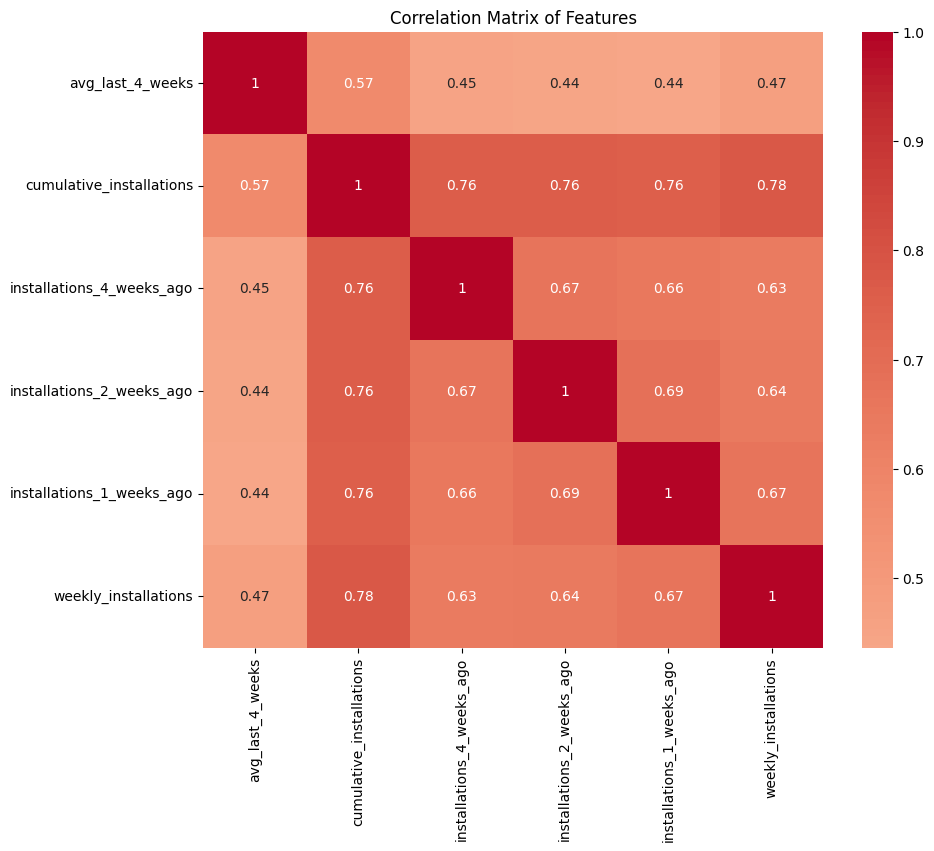

Mean Squared Error on Training Set: 0.11335267582665715
Mean Absolute Error on Training Set: 0.12218419001266638
Root Mean Squared Error on Training Set: 0.33667889126979306
R2 on Training Set: 0.9439545986663581
Mean Squared Error on Validation Set: 1.0539555458529533
Mean Absolute Error on Validation Set: 0.5420478592167336
Root Mean Squared Error on Validation Set: 1.0266233709851695
R2 on Validation Set: 0.6769458351034894


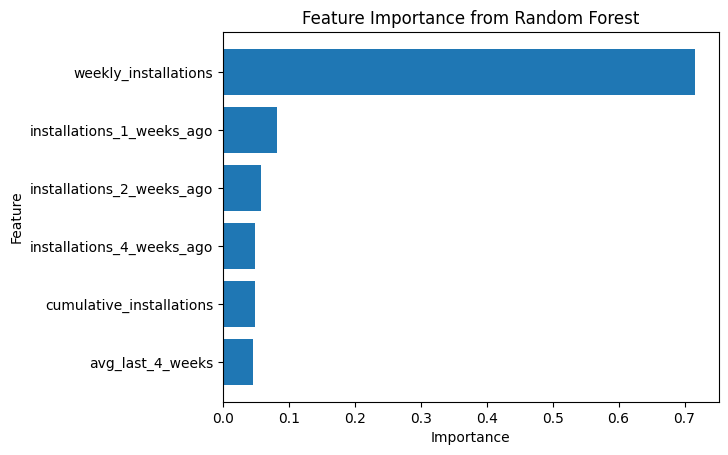

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming your DataFrame is named final_df

# Setting up features and target
features = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']
X = final_df[features]
y = final_df['weekly_service_cases']

# Time-based split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Using the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Correlation Matrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

# Train the Random Forest model (with model initialization)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the imputed data to train the model
model.fit(X_train_imputed, y_train)

# Predict and evaluate on the training set using the imputed data
y_train_pred = model.predict(X_train_imputed)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"Mean Squared Error on Training Set: {mse_train}")
print(f"Mean Absolute Error on Training Set: {mae_train}")
print(f"Root Mean Squared Error on Training Set: {rmse_train}")
print(f"R2 on Training Set: {r2_train}")

# Predict and evaluate on the validation set using the imputed data
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R2 on Validation Set: {r2}")

# Feature importance using the defined features (since RFE was commented out)
importances = model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(features, importances[sorted_idx])  # Use 'features' instead of 'selected_features'
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()

Mean Squared Error on Training Set: 0.11335267582665715
Mean Squared Error on Validation Set: 1.0539555458529533


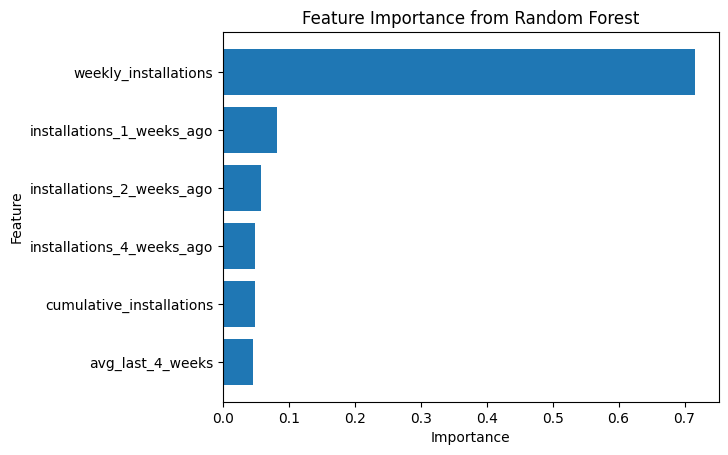

In [ ]:
# Initialize and train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

# Predict and evaluate on the training set
y_train_pred = model.predict(X_train_imputed)
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Set: {mse_train}")

# Predict and evaluate on the validation set
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Validation Set: {mse}")

# Feature importance
importances = model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(features, importances[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()

## Actually predict for two digit zip code

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Assuming your DataFrame is named final_df

# Convert the 'Installation End Date' column to datetime format
final_df['Installation End Date'] = pd.to_datetime(final_df['Installation End Date'])

# Setting up features and target
features = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']
X = final_df[features]
y = final_df['weekly_service_cases']

# Time-based split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Using the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the Random Forest model (with model initialization)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the imputed data to train the model
model.fit(X_train_imputed, y_train)

trained_columns = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']

def train_model_for_week(X_train, y_train, week_ahead):
    # Define base features
    base_features = [
        'avg_last_4_weeks',
        'cumulative_installations',
        'installations_4_weeks_ago',
        'installations_2_weeks_ago',
        'installations_1_weeks_ago',
        'weekly_installations'
    ]

    # Select features based on the week ahead
    features_to_use = base_features[-week_ahead:]

    # Train the model using the relevant features
    X_train_week = X_train[features_to_use]

    # Impute and fit
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_week)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_imputed, y_train)

    return model, imputer, features_to_use

def forecast_next_weeks_for_zip(models, imputers, features_list, input_data_for_zip, weeks_ahead):
    forecasts_for_zip = []

    for week in range(1, weeks_ahead + 1):
        model, imputer, features_to_use = models[week-1], imputers[week-1], features_list[week-1]

        # Use the model trained for this week to predict
        relevant_data = input_data_for_zip[features_to_use]
        X_imputed = imputer.transform(relevant_data)
        prediction = model.predict(X_imputed)[0]

        forecasts_for_zip.append({
            'zip_code': input_data_for_zip['zip_code_2_digits'].iloc[0],
            f'prediction_week_{week}': prediction
        })

    return forecasts_for_zip

# Prepare the models, imputers, and features for each week
models, imputers, features_list = [], [], []
for week_ahead in range(1, 5):  # 4 weeks ahead
    model, imputer, features_to_use = train_model_for_week(X_train, y_train, week_ahead)
    models.append(model)
    imputers.append(imputer)
    features_list.append(features_to_use)

# Prepare the latest_data
specified_date = '2023-08-07'
latest_data = final_df[final_df['Installation End Date'] == specified_date]

# The main loop for accumulating results
all_predictions = []

# Forecast for each zip code
for _, row in latest_data.iterrows():
    row_df = pd.DataFrame(row).transpose()  # Convert the series back to a DataFrame for processing
    predictions_for_zip = forecast_next_weeks_for_zip(models, imputers, features_list, row_df, 4)
    all_predictions.extend(predictions_for_zip)

# Convert all_predictions to a DataFrame
df_predictions = pd.DataFrame(all_predictions)

# Group by zip_code and aggregate the predictions
agg_funcs = {}
for col in df_predictions.columns:
    if 'prediction' in col:
        agg_funcs[col] = 'first'  # We just want the first non-NaN value

df_wide_two_digit_zip = df_predictions.groupby('zip_code').agg(agg_funcs).reset_index()

In [ ]:
df_wide_two_digit_zip

,zip_code,prediction_week_1,prediction_week_2,prediction_week_3,prediction_week_4
0,01,0.952727,0.902284,1.007568,0.675500
1,02,0.610024,0.417770,0.671109,0.411722
2,03,0.145114,0.145114,0.145114,0.145114
3,04,1.084901,1.261945,1.492897,1.173333
4,06,1.179403,1.541488,2.746095,2.965000
...,...,...,...,...,...
90,95,0.610024,0.668991,0.588437,0.770000
91,96,1.277497,1.625783,0.600619,1.060500
92,97,1.179403,0.859149,2.583000,2.760000
93,98,0.312768,0.212543,0.267590,0.077410


In [ ]:
# Saving the wide format dataframe to CSV
df_wide_two_digit_zip.to_csv('predictions_wide_2_digit_zip.csv')

## Baseline for two digit zip code

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Shift the 'weekly_service_cases' by one week to get the "predictions" from the previous week
final_df_baseline = final_df.copy()  # It's better to use .copy() to ensure the original dataframe remains unchanged
final_df_baseline['baseline_prediction'] = final_df_baseline['weekly_service_cases'].shift(1)

# Drop the first row, as it won't have a prediction
final_df_baseline.dropna(subset=['baseline_prediction'], inplace=True)

# Calculate the metrics
mse_baseline = mean_squared_error(final_df_baseline['weekly_service_cases'], final_df_baseline['baseline_prediction'])
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(final_df_baseline['weekly_service_cases'], final_df_baseline['baseline_prediction'])
mae_baseline = mean_absolute_error(final_df_baseline['weekly_service_cases'], final_df_baseline['baseline_prediction'])

print(f"Baseline Model's Mean Squared Error: {mse_baseline}")
print(f"Baseline Model's Root Mean Squared Error: {rmse_baseline}")
print(f"Baseline Model's R2: {r2_baseline}")
print(f"Baseline Model's Mean Absolute Error: {mae_baseline}")


Baseline Model's Mean Squared Error: 3.4648687012065293
Baseline Model's Root Mean Squared Error: 1.8614157787035461
Baseline Model's R2: -0.5220732538099613
Baseline Model's Mean Absolute Error: 1.0042583392476934


In [ ]:
from sklearn.metrics import r2_score

# Assuming your DataFrame is named final_df
final_df_sorted = final_df.sort_values(by=['Installation End Date', 'zip_code_2_digits'])

# Extract the features and target variable
features = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']
X = final_df_sorted[features]
y = final_df_sorted['weekly_service_cases']

# Using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Taking the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Baseline Model: Predict using last week's numbers
y_pred_baseline = X_test['weekly_installations']

# Calculate MSE for the baseline model
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
print(f"Baseline Model MSE: {mse_baseline}")

# Calculate R2 for the baseline model
r2_baseline = r2_score(y_test, y_pred_baseline)
print(f"Baseline Model R2: {r2_baseline}")

# Calculate MAPE for the baseline model
mape_baseline = 100 * (abs((y_test - y_pred_baseline) / y_test)).mean()
print(f"Baseline Model MAPE: {mape_baseline:.2f}%")

Baseline Model MSE: 45.14833215046132
Baseline Model R2: -12.838683041924519
Baseline Model MAPE: inf%


## We'll test ARIMA (time series forecasting)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

unique_zip_codes = final_df['zip_code_2_digits'].unique()

all_forecasts = []
all_actuals = []
all_mse = []

for zip_code in unique_zip_codes:
    zip_data = final_df[final_df['zip_code_2_digits'] == zip_code]

    # split the data into train and test
    train_size = int(len(zip_data) * 0.8)
    train, test = zip_data[0:train_size], zip_data[train_size:]

    try:
        # Fit the ARIMA model
        model = ARIMA(train['weekly_service_cases'], order=(5,1,0))
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=len(test))

        mse = mean_squared_error(test['weekly_service_cases'], forecast)
        all_mse.append(mse)

        all_forecasts.extend(forecast)
        all_actuals.extend(test['weekly_service_cases'].tolist())
    except:
        # It's possible for ARIMA to fail for certain series, so we use a try-except to continue
        print(f"ARIMA model failed for zip code {zip_code}.")
        continue

# Calculate overall MSE
overall_mse = mean_squared_error(all_actuals, all_forecasts)
print(f'Overall Mean Squared Error for ARIMA across all zip codes: {overall_mse}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Overall Mean Squared Error for ARIMA across all zip codes: 2.8765205172271116


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An u

In [ ]:
overall_mse

2.8765205172271116

## Random Forest for one digit zip code

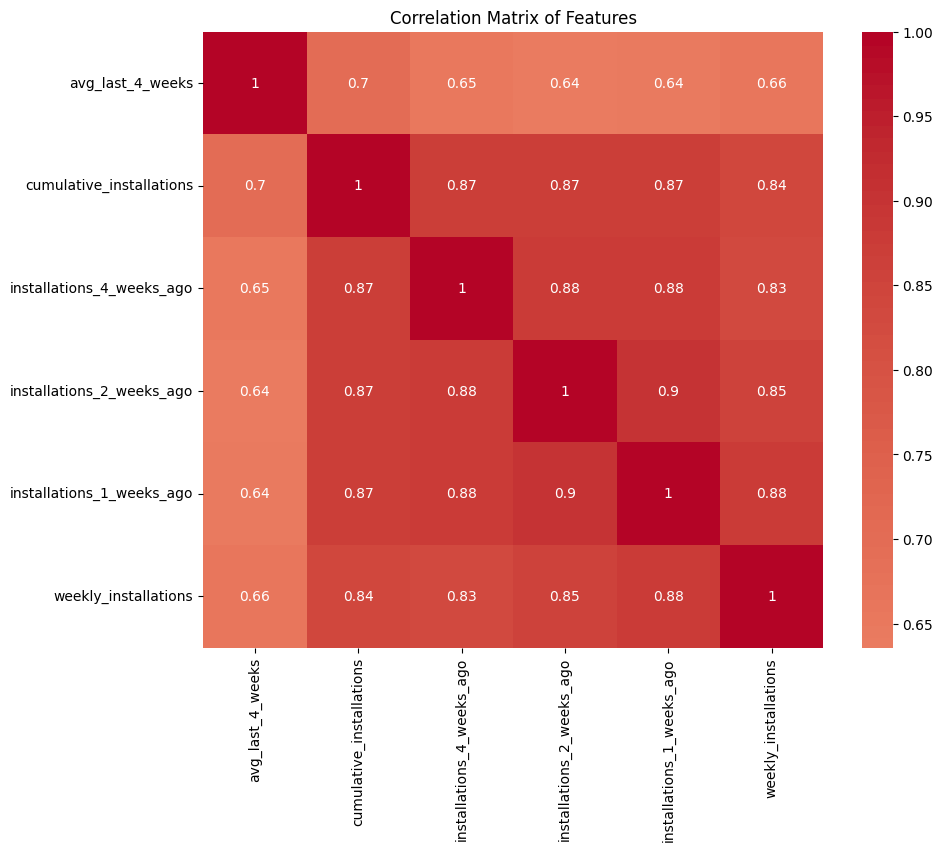

Mean Squared Error on Training Set: 1.0565469002695418
Mean Absolute Error on Training Set: 0.6143396226415093
Root Mean Squared Error on Training Set: 1.0278846726503619
R2 on Training Set: 0.9787336312518617
Mean Squared Error on Validation Set: 12.718389864864864
Mean Absolute Error on Validation Set: 2.486824324324324
Root Mean Squared Error on Validation Set: 3.566285163144538
R2 on Validation Set: 0.8505500031919591


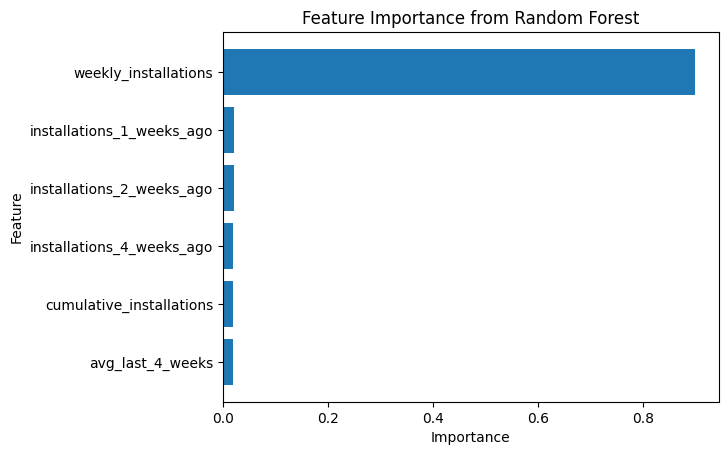

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming your DataFrame is named final_df

# Setting up features and target
features = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']
X = grouped_df[features]
y = grouped_df['weekly_service_cases']

# Time-based split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Using the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Correlation Matrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

# Train the Random Forest model (with model initialization)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the imputed data to train the model
model.fit(X_train_imputed, y_train)

# Predict and evaluate on the training set using the imputed data
y_train_pred = model.predict(X_train_imputed)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"Mean Squared Error on Training Set: {mse_train}")
print(f"Mean Absolute Error on Training Set: {mae_train}")
print(f"Root Mean Squared Error on Training Set: {rmse_train}")
print(f"R2 on Training Set: {r2_train}")

# Predict and evaluate on the validation set using the imputed data
y_pred = model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error on Validation Set: {mse}")
print(f"Mean Absolute Error on Validation Set: {mae}")
print(f"Root Mean Squared Error on Validation Set: {rmse}")
print(f"R2 on Validation Set: {r2}")

# Feature importance using the defined features (since RFE was commented out)
importances = model.feature_importances_
sorted_idx = importances.argsort()

plt.barh(features, importances[sorted_idx])  # Use 'features' instead of 'selected_features'
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()

## Actually Predict on Random Forest (one digit zip)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Assuming your DataFrame is named final_df

# Convert the 'Installation End Date' column to datetime format
grouped_df['Installation End Date'] = pd.to_datetime(grouped_df['Installation End Date'])

# Setting up features and target
features = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']
X = grouped_df[features]
y = grouped_df['weekly_service_cases']

# Time-based split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Using the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Impute missing values in features
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the Random Forest model (with model initialization)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the imputed data to train the model
model.fit(X_train_imputed, y_train)

trained_columns = ['avg_last_4_weeks', 'cumulative_installations', 'installations_4_weeks_ago', 'installations_2_weeks_ago', 'installations_1_weeks_ago', 'weekly_installations']

def train_model_for_week(X_train, y_train, week_ahead):
    # Define base features
    base_features = [
        'avg_last_4_weeks',
        'cumulative_installations',
        'installations_4_weeks_ago',
        'installations_2_weeks_ago',
        'installations_1_weeks_ago',
        'weekly_installations'
    ]

    # Select features based on the week ahead
    features_to_use = base_features[-week_ahead:]

    # Train the model using the relevant features
    X_train_week = X_train[features_to_use]

    # Impute and fit
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train_week)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_imputed, y_train)

    return model, imputer, features_to_use

def forecast_next_weeks_for_zip(models, imputers, features_list, input_data_for_zip, weeks_ahead):
    forecasts_for_zip = []

    for week in range(1, weeks_ahead + 1):
        model, imputer, features_to_use = models[week-1], imputers[week-1], features_list[week-1]

        # Use the model trained for this week to predict
        relevant_data = input_data_for_zip[features_to_use]
        X_imputed = imputer.transform(relevant_data)
        prediction = model.predict(X_imputed)[0]

        forecasts_for_zip.append({
            'zip_code': input_data_for_zip['zip_code'].iloc[0],
            f'prediction_week_{week}': prediction
        })

    return forecasts_for_zip

# Prepare the models, imputers, and features for each week
models, imputers, features_list = [], [], []
for week_ahead in range(1, 5):  # 4 weeks ahead
    model, imputer, features_to_use = train_model_for_week(X_train, y_train, week_ahead)
    models.append(model)
    imputers.append(imputer)
    features_list.append(features_to_use)

# Prepare the latest_data
specified_date = '2023-08-07'
latest_data = grouped_df[grouped_df['Installation End Date'] == specified_date]

# The main loop for accumulating results
all_predictions = []

# Forecast for each zip code
for _, row in latest_data.iterrows():
    row_df = pd.DataFrame(row).transpose()  # Convert the series back to a DataFrame for processing
    predictions_for_zip = forecast_next_weeks_for_zip(models, imputers, features_list, row_df, 4)
    all_predictions.extend(predictions_for_zip)

# Convert all_predictions to a DataFrame
df_predictions = pd.DataFrame(all_predictions)

# Group by zip_code and aggregate the predictions
agg_funcs = {}
for col in df_predictions.columns:
    if 'prediction' in col:
        agg_funcs[col] = 'first'  # We just want the first non-NaN value

df_wide = df_predictions.groupby('zip_code').agg(agg_funcs).reset_index()

In [ ]:
df_wide

,zip_code,prediction_week_1,prediction_week_2,prediction_week_3,prediction_week_4
0,0,3.487808,4.850000,5.490000,4.68
1,1,7.645665,1.945667,5.210000,9.31
2,2,12.668381,16.440000,12.875000,11.35
3,3,17.631667,24.170000,22.760000,23.66
4,4,12.065624,11.355000,10.848333,9.83
5,5,14.814429,33.920000,24.190000,24.22
6,6,13.449628,10.780000,12.370000,15.68
7,7,15.721132,12.795000,14.500000,11.71
8,8,4.332859,1.230833,2.820000,5.99
9,9,6.944034,4.674167,6.120000,7.96


In [ ]:
# Saving the wide format dataframe to CSV
df_wide.to_csv('predictions_wide.csv')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Shift the 'weekly_service_cases' by one week to get the "predictions" from the previous week
grouped_df_baseline = grouped_df.copy()  # It's better to use .copy() to ensure the original dataframe remains unchanged
grouped_df_baseline['baseline_prediction'] = grouped_df_baseline['weekly_service_cases'].shift(1)

# Drop the first row, as it won't have a prediction
grouped_df_baseline.dropna(subset=['baseline_prediction'], inplace=True)

# Calculate the metrics
mse_baseline = mean_squared_error(grouped_df_baseline['weekly_service_cases'], grouped_df_baseline['baseline_prediction'])
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(grouped_df_baseline['weekly_service_cases'], grouped_df_baseline['baseline_prediction'])
mae_baseline = mean_absolute_error(grouped_df_baseline['weekly_service_cases'], grouped_df_baseline['baseline_prediction'])

print(f"Baseline Model's Mean Squared Error: {mse_baseline}")
print(f"Baseline Model's Root Mean Squared Error: {rmse_baseline}")
print(f"Baseline Model's R2: {r2_baseline}")
print(f"Baseline Model's Mean Absolute Error: {mae_baseline}")

Baseline Model's Mean Squared Error: 48.584926884139485
Baseline Model's Root Mean Squared Error: 6.9702888666209155
Baseline Model's R2: 0.18728391880071116
Baseline Model's Mean Absolute Error: 4.857142857142857


## Fresh Start with less features

In [ ]:
# Make a copy of final_df to work with
new_final_df = final_df.copy()

# Convert the 'Installation End Date' column to datetime format (if not already done)
new_final_df['Installation End Date'] = pd.to_datetime(new_final_df['Installation End Date'])

# Get unique zip codes
unique_zip_codes = new_final_df['zip_code_2_digits'].unique()

# New dates we want to append
new_dates = [pd.Timestamp('2023-09-18'), pd.Timestamp('2023-09-25')]

# Create a new dataframe with these new dates for each zip code
new_rows = []
for date in new_dates:
    for zip_code in unique_zip_codes:
        new_rows.append({'Installation End Date': date, 'zip_code_2_digits': zip_code})

df_new_entries = pd.DataFrame(new_rows)

# Combine with the original dataframe
new_final_df = pd.concat([new_final_df, df_new_entries], axis=0).reset_index(drop=True)

# Now, we'll perform the shifting of values
new_final_df['installations_two_weeks_ago'] = new_final_df.groupby('zip_code_2_digits')['weekly_installations'].transform(lambda x: x.shift(2))
new_final_df['installations_four_weeks_ago'] = new_final_df.groupby('zip_code_2_digits')['weekly_installations'].transform(lambda x: x.shift(4))
new_final_df['cumulative_installations_two_weeks_ago'] = new_final_df.groupby('zip_code_2_digits')['cumulative_installations'].shift(2)

# Drop columns if needed
new_final_df.drop(columns=['weekly_installations', 'installations_1_weeks_ago', "avg_last_4_weeks", "cumulative_installations", "installations_2_weeks_ago", "installations_4_weeks_ago"], inplace=True, errors='ignore')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Assuming your DataFrame is named new_final_df

# Extract features and target for model training
features = ['installations_four_weeks_ago', 'installations_two_weeks_ago', 'cumulative_installations_two_weeks_ago']
X_train = new_final_df[new_final_df['Installation End Date'] <= '2023-08-21'][features]
y_train = new_final_df[new_final_df['Installation End Date'] <= '2023-08-21']['weekly_service_cases']

# Impute any missing data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Train a random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

# Extract the data for the zip codes for the future weeks
dates_to_predict = ['2023-09-18', '2023-09-25']
future_data = new_final_df[new_final_df['Installation End Date'].isin(dates_to_predict)]

# Predict for each zip code for the future dates
predictions_list = []
for _, row in future_data.iterrows():
    prediction_input = imputer.transform([row[features].values])
    prediction = model.predict(prediction_input)[0]

    # Append the prediction to the list
    predictions_list.append({
        'zip_code': row['zip_code_2_digits'],
        'date': row['Installation End Date'],
        'prediction': prediction
    })

# Convert the result to a DataFrame
predictions_df = pd.DataFrame(predictions_list)

# Convert to wide format
predictions_wide = predictions_df.pivot(index='zip_code', columns='date', values='prediction').reset_index()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Simpl

In [ ]:
predictions_wide

date,zip_code,2023-09-18 00:00:00,2023-09-25 00:00:00
0,01,2.446667,1.280000
1,02,1.077262,0.956333
2,03,0.160000,0.110000
3,04,2.130000,3.850000
4,06,3.480000,3.670000
...,...,...,...
90,95,1.480000,0.623333
91,96,1.626667,2.100000
92,97,3.100000,1.680000
93,98,0.230000,0.066388


In [ ]:
predictions_wide.to_csv('predictions_wide_new.csv')

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from datetime import timedelta

# Assuming your DataFrame is named new_final_df
features = ['installations_four_weeks_ago', 'installations_two_weeks_ago', 'cumulative_installations_two_weeks_ago']

# Function to train and predict for a given week
def train_and_predict_for_week(end_date):
    # Split data
    X_train = new_final_df[new_final_df['Installation End Date'] < end_date][features]
    y_train = new_final_df[new_final_df['Installation End Date'] < end_date]['weekly_service_cases']

    # Filter rows with NaN target
    mask = ~y_train.isna()
    X_train = X_train[mask]
    y_train = y_train[mask]

    # If after removing NaN values there's no data left, just return a list of NaN predictions
    if len(y_train) == 0:
        return [np.nan] * len(new_final_df[new_final_df['Installation End Date'] == end_date])

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_imputed, y_train)

    # Extract data for prediction
    X_pred = new_final_df[new_final_df['Installation End Date'] == end_date][features]
    X_pred_imputed = imputer.transform(X_pred)

    # Predict
    predictions = model.predict(X_pred_imputed)

    return predictions

# Get the recent date in the data
recent_date = new_final_df['Installation End Date'].max()

# Predict for the last 10 weeks
prediction_results = []
for i in range(10):
    target_date = recent_date - timedelta(weeks=i)
    week_predictions = train_and_predict_for_week(target_date)

    for zip_code, pred in zip(new_final_df[new_final_df['Installation End Date'] == target_date]['zip_code_2_digits'], week_predictions):
        prediction_results.append({
            'zip_code': zip_code,
            'date': target_date,
            'prediction': pred
        })

# Convert results to DataFrame
predictions_df = pd.DataFrame(prediction_results)

# Optionally convert to wide format
predictions_wide_new_new = predictions_df.pivot(index='zip_code', columns='date', values='prediction').reset_index()


In [ ]:
predictions_wide_new_new.to_csv('predictions_wide_new_new.csv')

Grouped DF

In [ ]:
# Make a copy of final_df to work with
new_grouped_df = grouped_df.copy()

# Convert the 'Installation End Date' column to datetime format (if not already done)
new_grouped_df['Installation End Date'] = pd.to_datetime(new_grouped_df['Installation End Date'])

# Get unique zip codes
unique_zip_codes = new_grouped_df['zip_code'].unique()

# New dates we want to append
new_dates = [pd.Timestamp('2023-09-18'), pd.Timestamp('2023-09-25')]

# Create a new dataframe with these new dates for each zip code
new_rows = []
for date in new_dates:
    for zip_code in unique_zip_codes:
        new_rows.append({'Installation End Date': date, 'zip_code': zip_code})

df_new_entries = pd.DataFrame(new_rows)

# Combine with the original dataframe
new_grouped_df = pd.concat([new_grouped_df, df_new_entries], axis=0).reset_index(drop=True)

# Now, we'll perform the shifting of values
new_grouped_df['installations_two_weeks_ago'] = new_grouped_df.groupby('zip_code')['weekly_installations'].transform(lambda x: x.shift(2))
new_grouped_df['installations_four_weeks_ago'] = new_grouped_df.groupby('zip_code')['weekly_installations'].transform(lambda x: x.shift(4))
new_grouped_df['cumulative_installations_two_weeks_ago'] = new_grouped_df.groupby('zip_code')['cumulative_installations'].shift(2)

# Drop columns if needed
new_grouped_df.drop(columns=['weekly_installations', 'installations_1_weeks_ago', "avg_last_4_weeks", "cumulative_installations", "installations_2_weeks_ago", "installations_4_weeks_ago"], inplace=True, errors='ignore')

In [ ]:
new_grouped_df

,Installation End Date,zip_code,weekly_service_cases,installations_two_weeks_ago,installations_four_weeks_ago,cumulative_installations_two_weeks_ago
0,2022-01-03,0,0.0,NaN,NaN,NaN
1,2022-01-03,1,0.0,NaN,NaN,NaN
2,2022-01-03,2,0.0,NaN,NaN,NaN
3,2022-01-03,3,0.0,NaN,NaN,NaN
4,2022-01-03,4,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
905,2023-09-25,5,NaN,40.0,105.0,7372.0
906,2023-09-25,6,NaN,18.0,71.0,5065.0
907,2023-09-25,7,NaN,15.0,64.0,3792.0
908,2023-09-25,8,NaN,12.0,33.0,2030.0


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from datetime import timedelta

# Assuming your DataFrame is named new_final_df
features = ['installations_four_weeks_ago', 'installations_two_weeks_ago', 'cumulative_installations_two_weeks_ago']

# Function to train and predict for a given week
def train_and_predict_for_week(end_date):
    # Split data
    X_train = new_grouped_df[new_grouped_df['Installation End Date'] < end_date][features]
    y_train = new_grouped_df[new_grouped_df['Installation End Date'] < end_date]['weekly_service_cases']

    # Filter rows with NaN target
    mask = ~y_train.isna()
    X_train = X_train[mask]
    y_train = y_train[mask]

    # If after removing NaN values there's no data left, just return a list of NaN predictions
    if len(y_train) == 0:
        return [np.nan] * len(new_grouped_df[new_grouped_df['Installation End Date'] == end_date])

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_imputed, y_train)

    # Extract data for prediction
    X_pred = new_grouped_df[new_grouped_df['Installation End Date'] == end_date][features]
    X_pred_imputed = imputer.transform(X_pred)

    # Predict
    predictions = model.predict(X_pred_imputed)

    return predictions

# Get the recent date in the data
recent_date = new_grouped_df['Installation End Date'].max()

# Predict for the last 10 weeks
prediction_results = []
for i in range(10):
    target_date = recent_date - timedelta(weeks=i)
    week_predictions = train_and_predict_for_week(target_date)

    for zip_code, pred in zip(new_grouped_df[new_grouped_df['Installation End Date'] == target_date]['zip_code'], week_predictions):
        prediction_results.append({
            'zip_code': zip_code,
            'date': target_date,
            'prediction': pred
        })

# Convert results to DataFrame
predictions_df = pd.DataFrame(prediction_results)

# Optionally convert to wide format
predictions_wide_new_new = predictions_df.pivot(index='zip_code', columns='date', values='prediction').reset_index()

In [ ]:
predictions_wide_new_new.to_csv('predictions_wide_new_new.csv')